# Extract Main Color from Images using BLIP VLM

This notebook uses the BLIP (Bootstrapped Language-Image Pretraining) model to extract the main color from product images.

BLIP is a vision-language model that can answer questions about images. We'll use its Visual Question Answering (VQA) capability to identify the main color in each image.


## 1. Setup and Installation

First, let's install the required packages if they're not already installed.


In [ ]:
# Install required packages
!pip install transformers pillow torch torchvision --quiet

: 

## 2. Import Libraries


In [3]:
import torch
from transformers import AutoProcessor, BlipForQuestionAnswering
from PIL import Image
import os
from pathlib import Path
import json
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Check if GPU is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


Using device: cuda


## 3. Load BLIP Model for Visual Question Answering

We'll use the BLIP VQA model from Salesforce, which is specifically designed for answering questions about images.


In [4]:
# Load BLIP VQA model and processor
model_name = "Salesforce/blip-vqa-base"
print(f"Loading model: {model_name}...")

processor = AutoProcessor.from_pretrained(model_name)
model = BlipForQuestionAnswering.from_pretrained(
    model_name,
    torch_dtype=torch.float16 if device == "cuda" else torch.float32
).to(device)

print("Model loaded successfully!")


Loading model: Salesforce/blip-vqa-base...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
`torch_dtype` is deprecated! Use `dtype` instead!


Model loaded successfully!


## 4. Define Helper Functions


In [5]:
def extract_main_color(image_path, question="What is the main color in this image?"):
    """
    Extract the main color from an image using BLIP VQA.
    
    Args:
        image_path: Path to the image file
        question: The question to ask about the image
    
    Returns:
        The predicted main color as a string
    """
    try:
        # Load and process image
        image = Image.open(image_path).convert('RGB')
        
        # Prepare inputs
        inputs = processor(images=image, text=question, return_tensors="pt").to(
            device, 
            torch.float16 if device == "cuda" else torch.float32
        )
        
        # Generate answer
        with torch.no_grad():
            outputs = model.generate(**inputs, max_length=20)
        
        # Decode the answer
        answer = processor.decode(outputs[0], skip_special_tokens=True)
        
        return answer
    
    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")
        return None


def visualize_results(image_path, color, figsize=(6, 6)):
    """
    Display an image with its detected main color.
    
    Args:
        image_path: Path to the image file
        color: The detected main color
        figsize: Figure size for display
    """
    image = Image.open(image_path)
    
    plt.figure(figsize=figsize)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Main Color: {color}", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


## 5. Test on a Single Image

Let's test the model on one image first to see how it performs.


Testing on: 30958.png

Detected main color: black


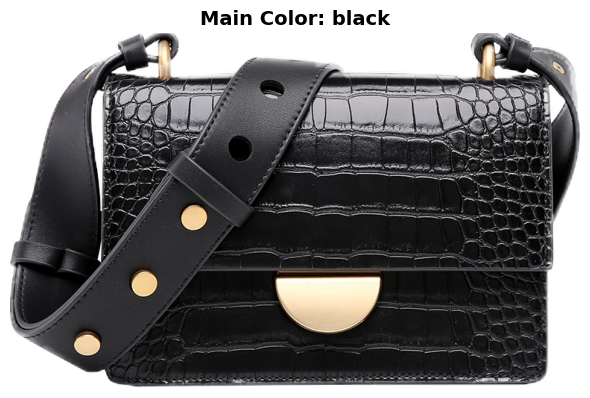

In [9]:
# Set the images directory
images_dir = Path("images")

# Get the first image for testing
test_images = list(images_dir.glob("*.png"))
if test_images:
    test_image = test_images[0]
    print(f"Testing on: {test_image.name}")
    
    # Extract color
    main_color = extract_main_color(test_image)
    print(f"\nDetected main color: {main_color}")
    
    # Visualize
    visualize_results(test_image, main_color)
else:
    print("No images found in the images directory!")


## 6. Process All Images

Now let's process all images in the directory and extract their main colors.


In [10]:
# Get all image files
image_files = sorted(images_dir.glob("*.png"))
print(f"Found {len(image_files)} images to process\n")

# Dictionary to store results
color_results = {}

# Process each image
for image_path in tqdm(image_files, desc="Extracting colors"):
    image_id = image_path.stem  # Get filename without extension
    main_color = extract_main_color(image_path)
    
    if main_color:
        color_results[image_id] = {
            "image_path": str(image_path),
            "main_color": main_color
        }

print(f"\nSuccessfully processed {len(color_results)} images")


Found 16472 images to process



Extracting colors:  30%|███       | 5023/16472 [07:49<15:07, 12.61it/s]

Error processing images/21561.png: image file is truncated


Extracting colors:  31%|███       | 5057/16472 [07:52<16:24, 11.59it/s]

Error processing images/21642.png: image file is truncated


Extracting colors:  67%|██████▋   | 11097/16472 [17:11<07:09, 12.51it/s]

Error processing images/35612.png: image file is truncated


Extracting colors: 100%|██████████| 16472/16472 [24:17<00:00, 11.30it/s]


Successfully processed 16469 images


## 7. Display Sample Results

Let's visualize a few examples to see how well the model performs.


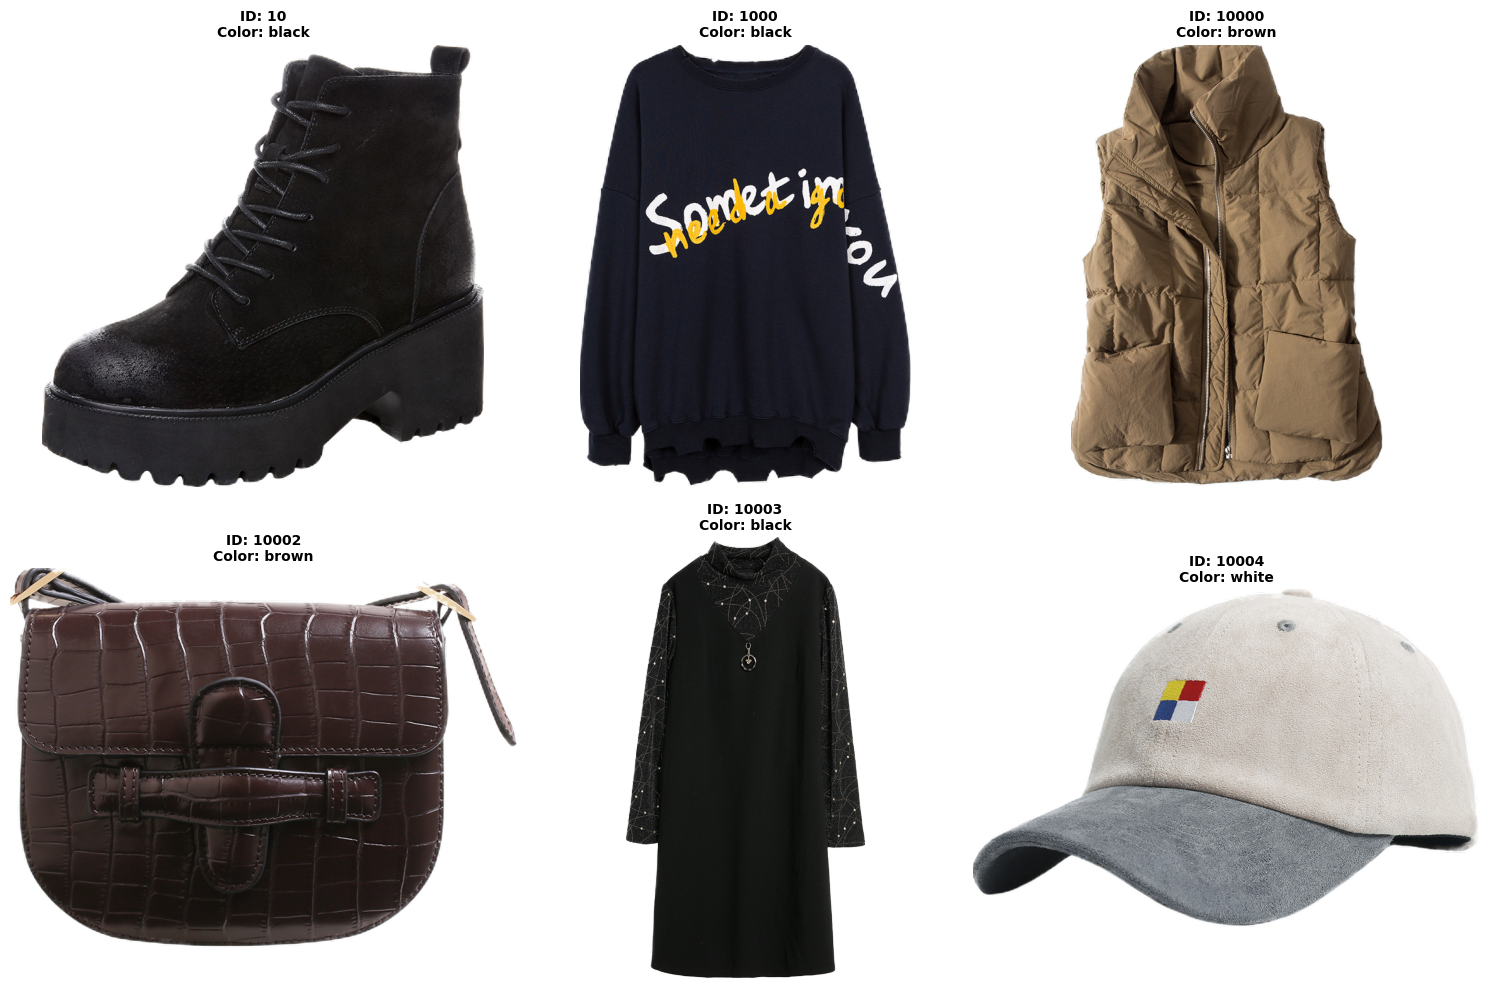

In [11]:
# Display first 6 results
sample_count = min(6, len(color_results))
sample_items = list(color_results.items())[:sample_count]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, (image_id, data) in enumerate(sample_items):
    if idx >= 6:
        break
    
    image = Image.open(data['image_path'])
    axes[idx].imshow(image)
    axes[idx].axis('off')
    axes[idx].set_title(f"ID: {image_id}\nColor: {data['main_color']}", 
                       fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()


## 8. Analyze Color Distribution

Let's see which colors are most common in our dataset.


Top 10 Most Common Colors:
black               : 4424 ( 26.9%)
white               : 3879 ( 23.6%)
blue                : 1777 ( 10.8%)
red                 : 1033 (  6.3%)
pink                : 1022 (  6.2%)
brown               : 1017 (  6.2%)
gray                : 872 (  5.3%)
tan                 : 830 (  5.0%)
green               : 427 (  2.6%)
yellow              : 347 (  2.1%)


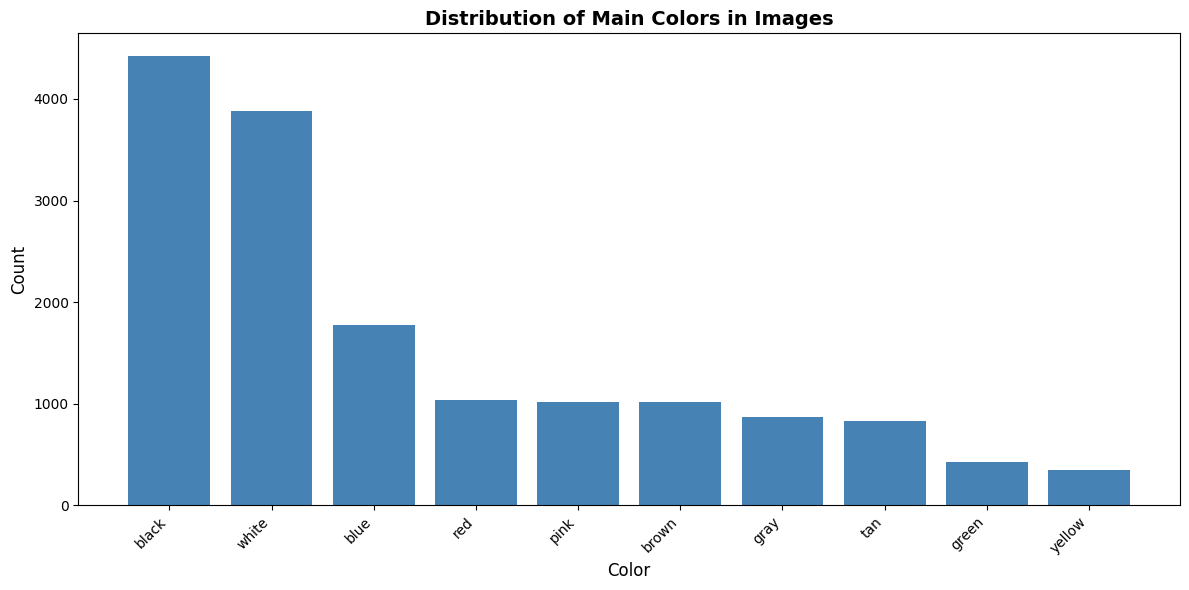

In [12]:
from collections import Counter

# Count color occurrences
colors = [data['main_color'].lower() for data in color_results.values()]
color_counts = Counter(colors)

# Display top 10 colors
print("Top 10 Most Common Colors:")
print("=" * 40)
for color, count in color_counts.most_common(10):
    percentage = (count / len(colors)) * 100
    print(f"{color:20s}: {count:3d} ({percentage:5.1f}%)")

# Visualize as bar chart
top_colors = color_counts.most_common(10)
if top_colors:
    colors_list, counts_list = zip(*top_colors)
    
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(colors_list)), counts_list, color='steelblue')
    plt.xticks(range(len(colors_list)), colors_list, rotation=45, ha='right')
    plt.xlabel('Color', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.title('Distribution of Main Colors in Images', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


## 9. Save Results to File

Save the extracted color information to a JSON file for future use.


In [13]:
# Save to JSON file
output_file = "image_colors.json"

with open(output_file, 'w') as f:
    json.dump(color_results, f, indent=2)

print(f"Results saved to {output_file}")
print(f"Total images processed: {len(color_results)}")


Results saved to image_colors.json
Total images processed: 16469


## 10. Advanced: Try Different Questions

We can also ask different questions to get more detailed color information.


Testing different questions on: 30958.png

Q: What is the main color in this image?
A: black

Q: What color is this product?
A: black

Q: What are the dominant colors in this image?
A: black

Q: Describe the color of this item
A: black



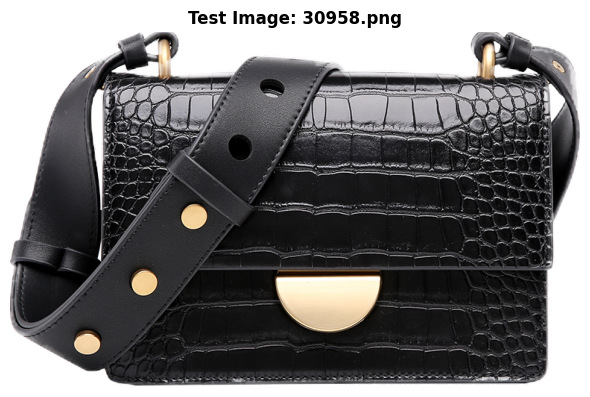

In [14]:
# Try different questions on the same image
if test_images:
    test_image = test_images[0]
    
    questions = [
        "What is the main color in this image?",
        "What color is this product?",
        "What are the dominant colors in this image?",
        "Describe the color of this item"
    ]
    
    print(f"Testing different questions on: {test_image.name}\n")
    
    for question in questions:
        answer = extract_main_color(test_image, question)
        print(f"Q: {question}")
        print(f"A: {answer}\n")
    
    # Show the image
    image = Image.open(test_image)
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Test Image: {test_image.name}", fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()


## Summary

This notebook demonstrated how to use BLIP's Visual Question Answering capabilities to extract the main color from images. The model can:

- Process images and answer natural language questions about them
- Identify main colors in product images
- Handle various phrasings of color-related questions

### Next Steps:
- Fine-tune the model on specific color categories if needed
- Combine with other vision models for more accurate color detection
- Extract additional visual features (style, pattern, material, etc.)
